# Project 6

* 4가지 분야(세계, 스포츠, 경제, 과학)의 영문 기사를 분석. 특정 기사가 어떤 범주에 속하는지 분류하는 알고리즘 개발
* 분야별 기사 30000개씩 (짧은 기사)
* 각 분야별로 학습 모델을 만들어서 단어벡터 생성.

* 특정 기사를 어떻게 '분류'할 것인지, 정확도를 어떻게 확인할 것인지 구상할 것.

## 데이터 학습

In [2]:
import gensim

text = []
with open("train.csv", encoding='utf-8') as file:
    line = file.readline()
    while line:
        if int(line[0]) == 3:
            text.append(gensim.utils.simple_preprocess(line[2:]))
        line = file.readline()

C:\Users\hyosa\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [3]:
model = gensim.models.Word2Vec (text, size=10, window=10, min_count=2, workers=4)
model.train(text, total_examples=len(text), epochs=500)

KeyboardInterrupt: 

가장 많이 등장하는 단어 찾기

In [17]:
maxcount = 0
maxword = str()
for word, obj in model.wv.vocab.items():
    if maxcount < obj.count:
        maxcount = obj.count
        maxword = word
print(maxword, maxcount)

the 44821


등장 빈도 높은 단어 순서대로 찾기

In [19]:
wordlist = []
count = []
for word, obj in model.wv.vocab.items():
    wordlist.append(word)
    count.append(obj.count)
for _ in range(100):
    idx = count.index(max(count))
    print(wordlist[idx], max(count))
    del count[idx]
    del wordlist[idx]

the 44821
to 30222
of 22781
in 22300
and 17190
on 16780
for 12165
its 9567
reuters 8717
as 8299
that 7345
said 7311
new 6632
it 6520
oil 6386
us 6171
by 6041
gt 5263
lt 5234
with 5052
is 4925
from 4848
at 4778
stocks 4518
inc 4425
company 4320
prices 4226
has 4172
after 4017
will 4014
fullquote 3626
an 3540
percent 3453
up 3419
york 3392
year 3335
corp 3119
profit 2904
million 2898
quarter 2795
sales 2786
more 2733
billion 2645
monday 2640
wednesday 2619
tuesday 2585
thursday 2524
than 2456
com 2404
friday 2395
over 2381
but 2344
shares 2292
be 2230
about 2212
target 2180
was 2167
third 2105
world 2088
quot 2062
are 2058
investor 2031
group 2028
yesterday 1964
market 1961
dollar 1946
have 1923
business 1858
http 1834
www 1828
href 1819
ticker 1819
aspx 1813
quickinfo 1813
largest 1805
bank 1786
co 1782
earnings 1779
this 1763
their 1762
week 1721
growth 1719
higher 1680
deal 1668
stock 1639
first 1609
federal 1578
two 1576
update 1534
against 1526
may 1523
chief 1521
high 1521
would 15

유사, 반대 단어 찾기

In [42]:
model.most_similar(positive=['business', 'stock'], negative=['government'], topn=20)

C:\Users\hyosa\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('cardiologist', 0.9377869367599487),
 ('behemoth', 0.9216551780700684),
 ('hp', 0.9211641550064087),
 ('eke', 0.9088259339332581),
 ('pirates', 0.8944269418716431),
 ('qvc', 0.8833740949630737),
 ('regain', 0.8776662945747375),
 ('listings', 0.8767327666282654),
 ('spinning', 0.8720331788063049),
 ('preview', 0.8639480471611023),
 ('soundview', 0.8637510538101196),
 ('yellow', 0.8625015020370483),
 ('inphonic', 0.8619570136070251),
 ('ebay', 0.8607845902442932),
 ('silicon', 0.8589580059051514),
 ('hewlett', 0.8564903140068054),
 ('nifty', 0.8523345589637756),
 ('cyberkinetics', 0.8501318693161011),
 ('heavyweight', 0.8500491380691528),
 ('initiated', 0.8423502445220947)]

두 단어벡터 간의 코사인 값 계산. (위의 결과와 비교)

In [32]:
import numpy as np

v1 = model.wv['business']
v2 = model.wv['pc']

print( np.dot(v1, v2) / np.linalg.norm(v1) / np.linalg.norm(v2))

0.8413098


t-SNE를 이용한 단어 군집 시각화 (비지니스 범주 기사 학습 모델 사용)
* https://towardsdatascience.com/google-news-and-leo-tolstoy-visualizing-word2vec-word-embeddings-with-t-sne-11558d8bd4d 참조함.

In [53]:
keys = ['business', 'market', 'company', 'government']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model.wv.most_similar(word, topn=50):
        words.append(similar_word)
        embeddings.append(model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, alpha = a, label = label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

과학 범주 기사에서 같은 keyword를 이용한 t-SNE

In [49]:
import gensim

text = []
with open("train.csv", encoding='utf-8') as file:
    line = file.readline()
    while line:
        if int(line[0]) == 4:
            text.append(gensim.utils.simple_preprocess(line[2:]))
        line = file.readline()
model4 = gensim.models.Word2Vec (text, size=10, window=10, min_count=2, workers=4)
model4.train(text, total_examples=len(text), epochs=100)

(91219782, 109183100)

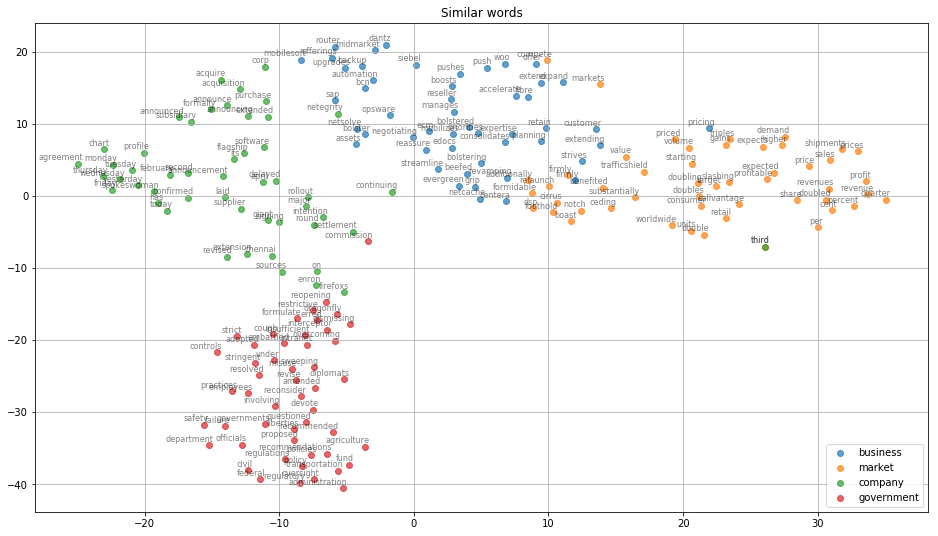

In [52]:
keys = ['business', 'market', 'company', 'government']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in model4.wv.most_similar(word, topn=50):
        words.append(similar_word)
        embeddings.append(model4.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)
    
from sklearn.manifold import TSNE
import numpy as np

embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=15, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

import matplotlib.pyplot as plt
import matplotlib.cm as cm


def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, alpha = a, label = label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=300, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')